In [9]:
import model
import importlib
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import sys
import yaml
import os
import copy
import pandas as pd
import pickle
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import proj3d

# class Arrow3D(FancyArrowPatch):

#     def _init_(self, x, y, z, dx, dy, dz, *args, **kwargs):
#         super()._init_((0, 0), (0, 0), *args, **kwargs)
#         self._xyz = (x, y, z)
#         self._dxdydz = (dx, dy, dz)

#     def draw(self, renderer):
#         x1, y1, z1 = self._xyz
#         dx, dy, dz = self._dxdydz
#         x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

#         xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
#         self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
#         super().draw(renderer)

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

class myArrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

def gazeto3d(gaze):
    gaze_gt = np.zeros([3])
    gaze_gt[0] = -np.cos(gaze[1]) * np.sin(gaze[0])
    gaze_gt[1] = -np.sin(gaze[1])
    gaze_gt[2] = -np.cos(gaze[1]) * np.cos(gaze[0])
    return gaze_gt


def angular(gaze, label):
    total = np.sum(gaze * label)
    return np.arccos(min(total / (np.linalg.norm(gaze) * np.linalg.norm(label)), 0.9999999)) * 180 / np.pi

def boxes2centers(normalized_boxes):
    center_x = (normalized_boxes[:,0] + normalized_boxes[:,2]) / 2
    center_y = (normalized_boxes[:,1] + normalized_boxes[:,3]) / 2
    center_x = np.expand_dims(center_x, axis=1)
    center_y = np.expand_dims(center_y, axis=1)
    normalized_centers = np.hstack((center_x, center_y))
    return normalized_centers

# def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
#     '''Add an 3d arrow to an `Axes3D` instance.'''
#
#     arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
#     ax.add_artist(arrow)


# setattr(Axes3D, 'arrow3D', _arrow3D)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

img_path = "/media/primesh/F4D0EA80D0EA4906/PROJECTS/FYP/Gaze detection/Datasets/gooreal/finalrealdatasetImgsV2/"
full_label_path = "/media/primesh/F4D0EA80D0EA4906/PROJECTS/FYP/Gaze detection/Datasets/gooreal/fullrealhumansNew.pkl"

labels = pd.read_pickle(full_label_path)

print("Model Loading")
net = model.GazeStatic()
statedict = torch.load("/media/primesh/F4D0EA80D0EA4906/PROJECTS/FYP/Gaze detection/saved_weights/gaze360_static_gaze360_1.pt")

net.to(device)
net.load_state_dict(statedict["state_dict"])
net.eval()

# setattr(Axes3D, 'arrow3D', _arrow3D)




Model Loading


GazeStatic(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

tensor([[ 1.1265, -0.1331]], device='cuda:0')


<ipython-input-9-8b23d1bb7f4a>:45: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


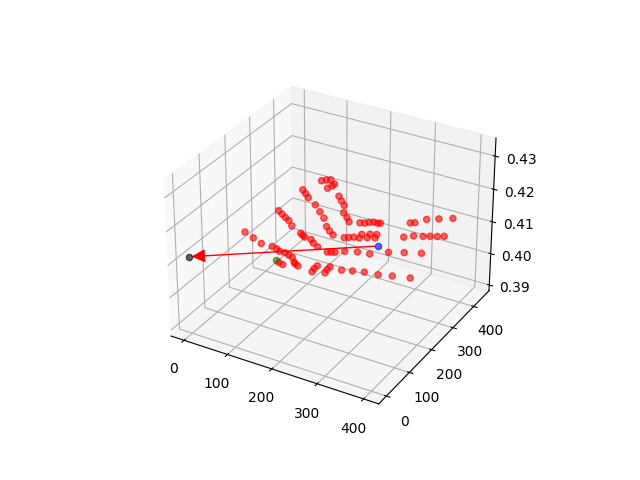

In [23]:
with torch.no_grad():
    for i in range(len(labels)):
        img_name = labels[i]["filename"]
        if img_name == "0\\cam0\\cam00000_img00123.jpg":
            bboxes = labels[i]["ann"]["bboxes"] / [640, 480, 640, 480]
            hbbox = labels[i]["ann"]["bboxes"][-1] / [640, 480, 640, 480]
            gtbox_id = labels[i]["gazeIdx"]
            img = cv2.imread(img_path + img_name.replace("\\", "/"))
            depth_img = cv2.imread("/media/primesh/F4D0EA80D0EA4906/PROJECTS/FYP/Gaze detection/monocular depth/depth_rebasing/cam00000_img00123_depth.png", 0)

            w, h = img.shape[1], img.shape[0]
            xmin, ymin, xmax, ymax = hbbox
            xmin, xmax = xmin * w, xmax * w
            ymin, ymax = ymin * h, ymax * h
            head_crop = img[int(ymin): int(ymax), int(xmin): int(xmax)]

            fimg = cv2.resize(head_crop, (448, 448)) / 255.0
            fimg = fimg.transpose(2, 0, 1)
            data = {"face": torch.from_numpy(fimg).type(torch.FloatTensor).unsqueeze(0).to(device)}

            gazes, gaze_bias = net(data)
            gaze = gazes[0].cpu().detach().numpy()
            gaze3d = gazeto3d(gaze)

            # 3D visualization
            points = boxes2centers(bboxes)

            # add depth
            points_d = []
            for i in range (len(points)):
                point = points[i]
                x, y = int(point[0]) * w, int(point[1]) * h
                z = depth_img[x, y] / 255.0
                if i==gtbox_id:
                    gtbox_c = [point[0]*224*2, point[1]*224*2, z]
                    continue
                points_d.append([point[0]*224*2, point[1]*224*2, z])
            points_d = np.array(points_d)
            
            head = points_d[-1]
            xyz = gaze3d
            
            fig = plt.figure()
            ax = plt.axes(projection='3d')
            ax.scatter3D(points_d[:-1, 0], points_d[:-1, 1], points_d[:-1, 2], marker='o', s=20, c="red", alpha=0.6)
            ax.scatter3D(gtbox_c[0], gtbox_c[1], gtbox_c[2], marker='o', s=20, c="g", alpha=0.6)
            ax.scatter3D(points_d[-1, 0], points_d[-1, 1], points_d[-1, 2], marker='o', s=20, c="blue", alpha=0.6)
            ax.scatter3D(xyz[0], xyz[1], head[2], marker='o', s=20, c="black", alpha=0.6)
   

#             a= Arrow3D(head[0]*10, head[1]*10, head[2]*10, xyz[0]*10, xyz[1]*10, xyz[2]*10, mutation_scale=20, arrowstyle="-|>")
            # a = myArrow3D([0, 0.7], [0, 0.5], [1, 1], mutation_scale=25, lw=1.5, arrowstyle="simple", color="b")
            a = Arrow3D([head[0], xyz[0]], [head[1], xyz[1]],[head[2], head[2]] , mutation_scale=20, arrowstyle="-|>", color="r")
            ax.add_artist(a)
#             plt.show()

            print (gazes)



In [18]:
points_d[0]

array([0.0921875 , 0.33020833, 0.41176471])

In [19]:
points[0]

array([0.0921875 , 0.33020833])